### P4.2 Symulacja ruchu kulek na siatce sprężynowej w 3D

Zadanie analogiczne do P4.1 - analiza w 3D.

In [1]:
%matplotlib inline
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D

def solve_vec(method, f, y0, rng, h):
    (K, N, M, D) = y0.shape
    t0, tn = rng
    
    t = np.arange(t0,tn,h)
    y = np.zeros((len(t), K, N, M, D), np.float64)
    y[0] = y0
    
    for ti in range(1, len(t)):
        y[ti] = method(f, t[ti-1], y[ti-1], h)
    return t, y

def euler_method(f, t, y, h):
    return y + h * f(t, y)

def midpoint_method(f, t, y, h):
    K1 = f(t, y)
    K2 = f(t+h*0.5, y+(h*0.5*K1))
    return y + h * K2

def RK4_method(f, t, y, h):
    K1 = f(t, y)
    K2 = f(t+h*0.5, y+(h*0.5*K1))
    K3 = f(t+h*0.5, y+(h*0.5*K2))
    K4 = f(t+h, y+(h*K3))
    return y + h*(K1/6+K2/3+K3/3+K4/6)

In [2]:
def getNeighbours(i,j,x):
    neighbours = []
    if i-1>=0:
        neighbours.append(x[i-1,j])
    if i+1<x.shape[0]:
        neighbours.append(x[i+1,j])
    if j-1>=0:
        neighbours.append(x[i,j-1])
    if j+1<x.shape[1]:
        neighbours.append(x[i,j+1])
    return neighbours

# force F for (i,j) ball - forces coming from neighbors
def F(i, j, x, k, l):
    f = np.array([0,0,0], np.float64)
    x_ij = x[i,j]
    for x_n in getNeighbours(i,j,x):
        d = np.linalg.norm(x_ij-x_n)
        f += ((x_n - x_ij)/d)*(d-l)*k
    return f

# force R for (i,j) ball - resistance
def R(i, j, xp, r, alpha):
    xp_ij = xp[i,j]
    if(np.linalg.norm(xp_ij) == 0.):
        return np.array([0,0,0], np.float64)
    
    f = (-r) * (np.linalg.norm(xp_ij)**alpha) * (xp_ij/np.linalg.norm(xp_ij))
    return f

# force G for (i,j) ball - gravitation
def G(i, j, m):
    f = np.array([0,0,-9.8 * m[i,j]])
    return f


N = 7 # rows
M = 7 # cols
r = 0.02 # resistance
alpha = 1 # resistance power
k = 5 # spring constant
l = 0.2 # length of spring at rest
l_after = 0.4 # l after stretching (distance between neighbours)
m = np.array([[0.005 for i in range(M+2)] for j in range(N+2)], np.float64) # mass

def f(t, y):
    (_, N, M, _) = y.shape
    values = np.zeros_like(y)
    for i in range(1,N-1):
        for j in range(1,M-1):
            values[:,i,j] = np.array([y[1,i,j], ( F(i,j,y[0],k,l) + R(i,j,y[1],r,alpha) ) / m[i,j]])
    return values

def f_gravity(t, y):
    (_, N, M, _) = y.shape
    values = np.zeros_like(y)
    for i in range(1,N-1):
        for j in range(1,M-1):
            values[:,i,j] = np.array([y[1,i,j], ( F(i,j,y[0],k,l) + R(i,j,y[1],r,alpha) + G(i,j,m) ) / m[i,j]])
    return values


# Initial state
x0 = np.array([ [ [l_after*j, l_after*i, 0.] for i in range(M+2) ] for j in range(N+2) ], np.float64)
xd0 = np.zeros_like(x0)
y0 = np.array([x0, xd0])

# Initial state for second problem (balls at rest)
t, y = solve_vec(RK4_method, f_gravity, y0, (0,20), 1/60.)
y0_static = y[-1]
y0_static[0, N/2+1, M/2+1] *= np.array([1,1,-1.0])

rng = (0,10)
h = 1/60.

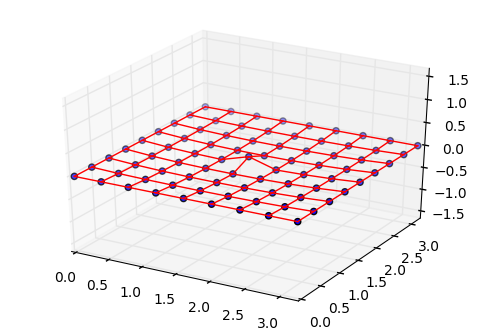

In [3]:
# draw initial state
(N,M,D) = y0_static[0].shape
x0_flat = np.reshape(y0_static[0], (N*M,D))

x_lim, y_lim = y0_static[0,-1,-1,0], y0_static[0,-1,-1,1]
z_lim_min = np.min(x0_flat[:,2])+l_after
z_lim_max = np.max(x0_flat[:,2])-l_after
xyz_lim = max(x_lim, y_lim, z_lim_max-z_lim_min)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, xyz_lim)
ax.set_ylim(0, xyz_lim)
ax.set_zlim(-xyz_lim/2, xyz_lim/2)

# plot springs
for row in range(N):
    ax.plot(y0_static[0,row,:,0], y0_static[0,row,:,1], zs=y0_static[0,row,:,2],c='r')
for col in range(M):
    ax.plot(y0_static[0,:,col,0], y0_static[0,:,col,1], zs=y0_static[0,:,col,2],c='r')

# plot balls
ax.scatter(x0_flat[:,0], x0_flat[:,1], x0_flat[:,2], s=20)

plt.show()

In [4]:
def balls_animation_3D(t, x, m, l, l_after, pre=''):
    (T,N,M,D) = x.shape
    x_flat = np.reshape(x[:,1:-1,1:-1], (T,(N-2)*(M-2),D))
    
    figsize = (18,12)
    dpi = 72
    width, height = figsize[0] * dpi, figsize[1] * dpi

    video = cv2.VideoWriter(
        'output/v3D_'+pre+'_'+str(time.time())+'.avi',
        cv2.VideoWriter_fourcc(*'MJPG'),
        len(t)//t[-1],(width,height))
    
    # mass dependent radius
    max_radius = 30
    (N,M) = m.shape
    r = np.reshape(m, (N*M))/np.max(m[1:-1,1:-1])
    r = (r**0.5)*max_radius
    
    x_lim = x0[-1,-1,0]
    y_lim = x0[-1,-1,1]
    z_lim_min = np.min(x0_flat[:,2])+l_after
    z_lim_max = np.max(x0_flat[:,2])-l_after
    xyz_lim = max(x_lim, y_lim, z_lim_max-z_lim_min)
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(len(t)):
        plt.cla()
        ax.set_xlim(0, xyz_lim)
        ax.set_ylim(0, xyz_lim)
        ax.set_zlim(-xyz_lim/2, xyz_lim/2)
        
        for row in range(N):
            ax.plot(x[i,row,:,0], x[i,row,:,1], zs=x[i,row,:,2],c='r')
        for col in range(M):
            ax.plot(x[i,:,col,0], x[i,:,col,1], zs=x[i,:,col,2],c='r')
        
        ax.scatter(x_flat[i,:,0], x_flat[i,:,1], x_flat[i,:,2], s=r)
        canvas = FigureCanvas(fig)
        ax2 = fig.gca()
        canvas.draw()
        frame = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
        video.write(frame)
        
    video.release()

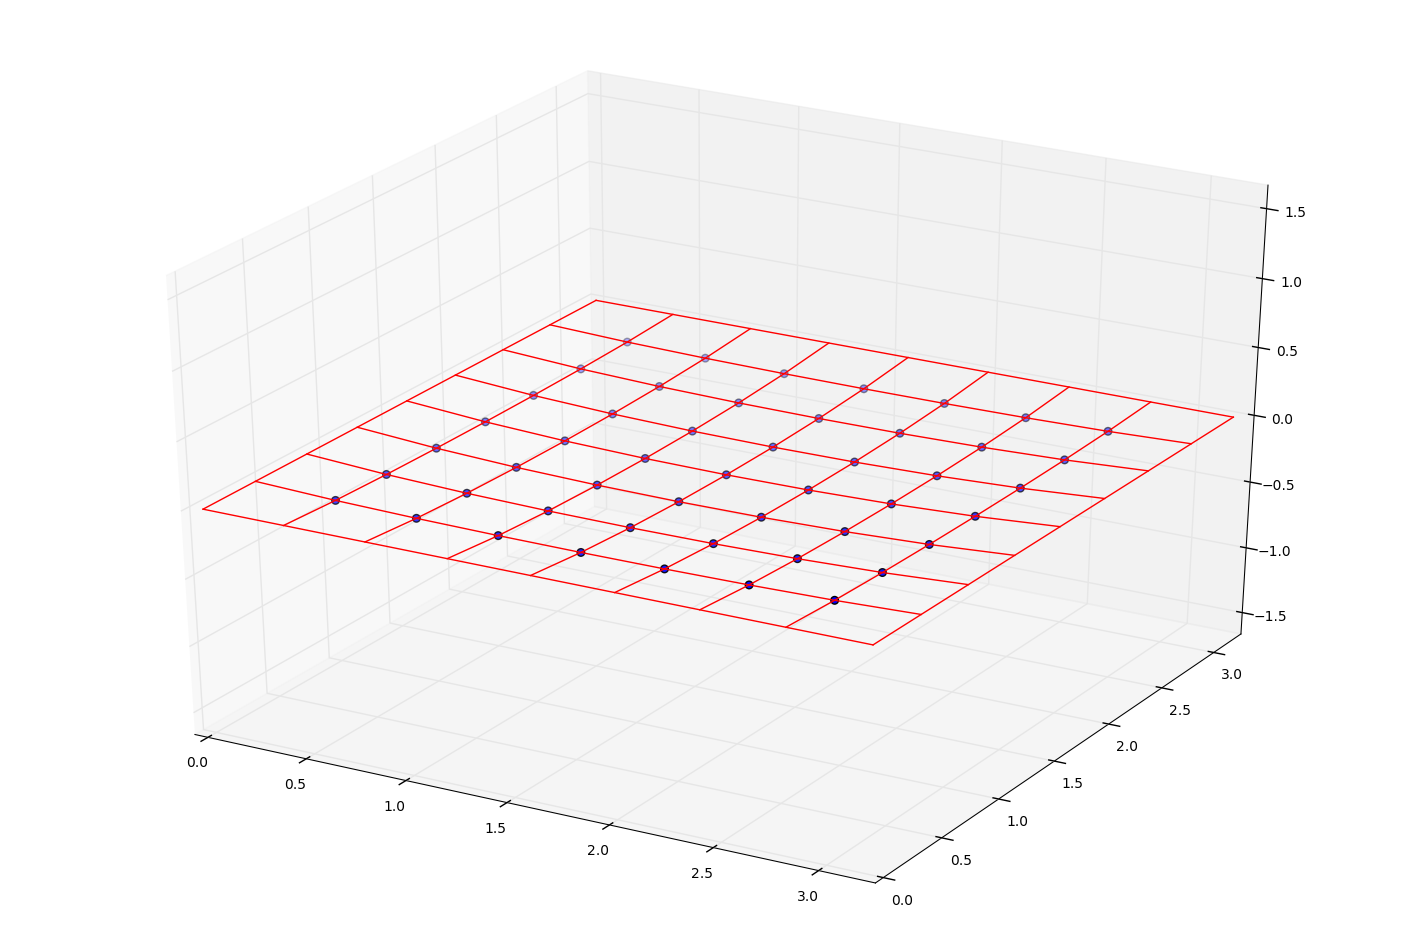

In [5]:
t, y = solve_vec(RK4_method, f_gravity, y0_static, rng, h)

balls_animation_3D(t, y[:,0], m, l, l_after, pre='grav_strained_RK4_k='+str(k))